<a href="https://colab.research.google.com/github/MohsenJadidi/Automatic-Modulation-Classification-AMC/blob/master/ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Importing the dataset

In [0]:
import pickle
fileName = 'RML2016.10a_dict.pkl'
with open("/content/drive/My Drive/Colab Notebooks/"+fileName,'rb') as f:
  data = pickle.load(f,encoding='bytes')
 

In [3]:
import numpy as np
X = []
labels = [] # label each example by a pair (modulation type, snr)
total_examples = 0
analog = [b'AM-DSB', b'AM-SSB', b'WBFM']

for mod_type, snr in data.keys():
    if (mod_type not in analog):      
        current_matrix = data[(mod_type, snr)]        
        total_examples += current_matrix.shape[0]
        for i in range(current_matrix.shape[0]):
            X.append(current_matrix[i])
            labels.append((str(mod_type, 'ascii'), snr)) # mod_type is of type bytes
    
X = np.array(X)         # First row is QPSK snr=2, seconde is PAM4 snr=8 , ...
labels = np.array(labels)

y = labels[:,0]

print(f'loaded {total_examples} signal vectors into X{X.shape} and their corresponding'
      f' labels into labels{labels.shape}')  
# print(np.unique(labels[:,0]))


loaded 160000 signal vectors into X(160000, 2, 128) and their corresponding labels into labels(160000, 2)


In [4]:
# Encoding categorical data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)
onehotencoder = OneHotEncoder()
y = onehotencoder.fit_transform(y.reshape(-1,1)).toarray()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [5]:
snrList = [str(2*i-20) for i in range(20)]  # snrList = -20, -18, -16 , ... ,0, ... ,18
snr = snrList[19]
numberOfEachExamples = 1000
print("SNR :", snrList)

SNR : ['-20', '-18', '-16', '-14', '-12', '-10', '-8', '-6', '-4', '-2', '0', '2', '4', '6', '8', '10', '12', '14', '16', '18']


In [0]:
output = [[labels[i*numberOfEachExamples, 0],y[i*numberOfEachExamples]] for i in range(int(X.shape[0]/numberOfEachExamples))]
output = dict(output)

In [7]:
Xsnr = np.zeros(shape=(X.shape[0],X.shape[1],X.shape[2]+1))
for i in range(X.shape[0]):
    snr = int(labels[i,1])
    Xsnr[i,0,:] = np.insert(X[i,0,:],0,snr)
    Xsnr[i,1,:] = np.insert(X[i,1,:],0,snr)
    
print(Xsnr.shape)

(160000, 2, 129)


In [8]:
###### Splitting the dataset into the Training set and Test set ######
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xsnr, y, test_size = 0.2, random_state = 0)
# The below line better for Cross_val part
#X_train, X_test, y_train, y_test = train_test_split(Xsnr, y, test_size = 1, random_state = 0)

print(X_train.shape)
print(X_test.shape)

(128000, 2, 129)
(32000, 2, 129)


In [9]:
X_train = X_train[:,:,1:] # snr important for train

y_test18 = []
X_test18 = []

for i in range(X_test.shape[0]):
    if X_test[i,0,0] == 18:
        X_test18.append(X_test[i])
        y_test18.append(y_test[i])
        
X_test18 = np.array(X_test18)
y_test18 = np.array(y_test18)        
X_test18 = X_test18[:,:,1:]


print(X_train.shape)
print(X_test18.shape)

(128000, 2, 128)
(1653, 2, 128)


In [10]:
# Change IQ to amplitude and phase
X_cmplx = X_train[:,0,:] + 1j* X_train[:,1,:]    
X_amp = np.abs(X_cmplx)
X_ang = np.arctan2(X_train[:,1,:],X_train[:,0,:]) / np.pi
    
X_amp = np.reshape(X_amp,(-1,1,128))
X_ang = np.reshape(X_ang,(-1,1,128))
    
X_train_AmpPhs = np.concatenate((X_amp,X_ang), axis=1) 
##
X_cmplx = X_test18[:,0,:] + 1j* X_test18[:,1,:]    
X_amp = np.abs(X_cmplx)
X_ang = np.arctan2(X_test18[:,1,:],X_test18[:,0,:]) / np.pi
    
X_amp = np.reshape(X_amp,(-1,1,128))
X_ang = np.reshape(X_ang,(-1,1,128))
    
X_test18_AmpPhs = np.concatenate((X_amp,X_ang), axis=1) 
##

print(X_train_AmpPhs.shape)
print(X_test18_AmpPhs.shape)

(128000, 2, 128)
(1653, 2, 128)


In [0]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = X_train.reshape([X_train.shape[0],256])
X_train = sc.fit_transform(X_train)
X_train = X_train.reshape([X_train.shape[0],2,128])
#X_test = X_test.reshape([1600,256])
X_test18 = X_test18.reshape([X_test18.shape[0],256])
X_test18 = sc.transform(X_test18)
X_test18 = X_test18.reshape([X_test18.shape[0],2,128])


In [0]:
X_train = X_train.reshape([X_train.shape[0],256])
X_test18 = X_test18.reshape([X_test18.shape[0],256])

# Making Simple model

In [17]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
# Initialising the ANN


classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 16896, kernel_initializer = 'uniform', activation = 'relu', input_dim = 256))
#dout = 0.4
#classifier.add(Dropout(rate = dout))

# Adding the second hidden layer
#classifier.add(Dense(units = 132, kernel_initializer = 'uniform', activation = 'relu'))
#classifier.add(Dropout(rate = dout))

#classifier.add(Dense(units = 132, kernel_initializer = 'uniform', activation = 'relu'))
#classifier.add(Dropout(rate = dout))

#classifier.add(Dense(units = 132, kernel_initializer = 'uniform', activation = 'relu'))
#classifier.add(Dropout(rate = dout))

#classifier.add(Dense(units = 132, kernel_initializer = 'uniform', activation = 'relu'))
#classifier.add(Dropout(rate = dout))

# Adding the output layer
classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#logger = keras.callbacks.TensorBoard(log_dir="./logs", write_graph=True, histogram_freq=0)

classifier.summary()

print("Model Created!")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16896)             4342272   
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 135176    
Total params: 4,477,448
Trainable params: 4,477,448
Non-trainable params: 0
_________________________________________________________________
Model Created!


In [18]:
batch = 1024
epoch = 100

history = classifier.fit(X_train, y_train, batch_size = batch, epochs = epoch, validation_data=(X_test18, y_test18))
#history = classifier.fit(X_train, y_train, batch_size = batch, epochs = epoch)

Train on 128000 samples, validate on 1653 samples
Epoch 1/100
128000/128000 [==============================] - 66s 516us/step - loss: 2.2302 - acc: 0.2702 - val_loss: 1.6867 - val_acc: 0.3926
Epoch 2/100
128000/128000 [==============================] - 66s 514us/step - loss: 1.5921 - acc: 0.4114 - val_loss: 1.4991 - val_acc: 0.4404
Epoch 3/100
128000/128000 [==============================] - 66s 514us/step - loss: 1.3334 - acc: 0.5055 - val_loss: 1.4287 - val_acc: 0.4646
Epoch 4/100
128000/128000 [==============================] - 66s 513us/step - loss: 1.1447 - acc: 0.5798 - val_loss: 1.3621 - val_acc: 0.4785
Epoch 5/100
128000/128000 [==============================] - 66s 513us/step - loss: 1.0029 - acc: 0.6343 - val_loss: 1.3420 - val_acc: 0.4979
Epoch 6/100
128000/128000 [==============================] - 66s 514us/step - loss: 0.8813 - acc: 0.6821 - val_loss: 1.2409 - val_acc: 0.5251
Epoch 7/100
128000/128000 [==============================] - 66s 514us/step - loss: 0.7763 - acc: 

# Save model

In [0]:
dic = "/content/drive/My Drive/Colab Notebooks/"
classifier.save(dic+f'SaveModel/ANN-16896-ba{batch}-ep{epoch}-(dout=0)-input(IQ)(SNR=all).h5')

f = open(dic+f'SaveModel/ANN-16896-ba{batch}-ep{epoch}-(dout=0)-input(IQ)(SNR=all)-history.txt',"w")
f.write( str(classifier.history.history) )
f.close()

print('Model Saved!')


# Prediction(only SNR=18)

In [0]:
y_pred = classifier.predict(X_test18)
y_pred = np.argmax(y_pred, axis=1)

y_real = np.argmax(y_test18, axis=1)
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_real, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

acc_test = classifier.evaluate(X_test18, y_test18)[1]
acc_train = classifier.evaluate(X_train, y_train)[1]

print("Acc Test : ", acc_test)
print("Acc Train : ", acc_train)

128000/128000 [==============================] - 3s 23us/step
Acc Test :  0.4996975198234851
Acc Train :  0.479921875


#Cross_val(mean accuracy)

In [0]:
# Evaluating the ANN
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

def build_classifier():
    classifier = Sequential()
    classifier.add(Dense(units = 132, kernel_initializer = 'uniform', activation = 'relu', input_dim = 256))    
    dout = 0.1
    classifier.add(Dropout(p = dout))
    classifier.add(Dense(units = 132, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dropout(p = dout))
    classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'softmax'))
    classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return classifier
classifier = KerasClassifier(build_fn = build_classifier)
batch = 10
epoch = 25
classifier = KerasClassifier(build_fn = build_classifier, batch_size = batch, epochs = epoch)
# It is better test_size = 1 in Splitting the dataset part
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 5, n_jobs = 1)
mean = accuracies.mean()
variance = accuracies.std()

# Accuracy vs Droupout

In [0]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

means = []
for i in range(16):
  def build_classifier():
      classifier = Sequential()
      classifier.add(Dense(units = 132, kernel_initializer = 'uniform', activation = 'relu', input_dim = 256))
      dout = 0.05*i
      classifier.add(Dropout(rate = dout))
      classifier.add(Dense(units = 132, kernel_initializer = 'uniform', activation = 'relu'))
      classifier.add(Dropout(rate = dout))
      classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'softmax'))
      classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
      return classifier

  print("Dropout :", 0.05*i)
  batch = 10
  epoch = 25
  classifier = KerasClassifier(build_fn = build_classifier, batch_size = batch, epochs = epoch, verbose=0)
  # It is better test_size = 1 in Splitting the dataset part
  accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 5, n_jobs = 1)
  mean = accuracies.mean()
  variance = accuracies.std()
  print(mean)
  means.append(mean)

In [0]:

import matplotlib.pyplot as plt

ax = plt.plot(d, means, 'ro')
plt.grid()
plt.title('Accuracy vs Dropout for ANN (SNR=18)')
plt.xlabel('Dropout', fontsize=8)
plt.ylabel('Accuracy', fontsize=8)
plt.ylim([0.30,0.5])
plt.yticks(np.arange(0.3, 0.5, step=0.02))


dic = "/content/drive/My Drive/Colab Notebooks/"
# fig = ax.get_figure()
plt.savefig(dic+f"/Pic/ANN-CrossVal(5)-132-132-ba{batch}-ep{epoch}(SNR={snr}).png", dpi=175, bbox_inches='tight')
plt.savefig(dic+f"/Pic/ANN-CrossVal(5)-132-132-ba{batch}-ep{epoch}(SNR={snr}).eps", bbox_inches='tight')

print("Plot Saved!")

# Grid Search

In [0]:
# Tuning the ANN
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout

def build_classifier(n1):
    classifier = Sequential()
    classifier.add(Dense(units = n1, kernel_initializer = 'uniform', activation = 'relu', input_dim = 256))    
    dout = 0.2
    classifier.add(Dropout(p = dout))
    classifier.add(Dense(units = n1, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dropout(p = dout))
    classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'softmax'))
    classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return classifier
classifier = KerasClassifier(build_fn = build_classifier)
parameters = {'batch_size': [10, 25, 50, 75, 100],
              'epochs': [10, 20, 50, 100],
              'optimizer': ['adam', 'rmsprop'],
              'n1':[66, 99, 165, 198, 231, 264, 297 ,396],
              'n2':[66, 99, 165, 198, 231, 264, 297 ,396]}

parameters = {'n1':[66, 99, 165, 198, 231, 264, 297 ,396]}
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 2)

grid_search = grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

print('best_parameters : ', best_parameters)
print('best_accuracy : ', best_accuracy)

# Plot Confusion Matrix

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

modulation_order = []
modulation_order_dict = dict()

for key,value in output.items():
    modulation_order_dict[np.argmax(value)] = str(key)
    
for i in range(8):
    modulation_order.append(modulation_order_dict[i])
    
acc_test = classifier.evaluate(X_test18, y_test18)[1]
acc_train = classifier.evaluate(X_train, y_train)[1]

print("Acc Test : ", acc_test)
print("Acc Train : ", acc_train)    

128000/128000 [==============================] - 3s 24us/step
Acc Test :  0.4996975198234851
Acc Train :  0.479921875


In [21]:
dic = "/content/drive/My Drive/Colab Notebooks/"
acc = []

for snr in snrList:
  print('SNR: ', snr)
    
  y_test_snr = []
  X_test_snr = []
  for i in range(X_test.shape[0]):
    if X_test[i,0,0] == int(snr):
      X_test_snr.append(X_test[i])
      y_test_snr.append(y_test[i])
        
  X_test_snr = np.array(X_test_snr)
  y_test_snr = np.array(y_test_snr)        
  X_test_snr = X_test_snr[:,:,1:]
  
  X_test_snr = X_test_snr.reshape([X_test_snr.shape[0],256])
  X_test_snr = sc.transform(X_test_snr)
  X_test_snr = X_test_snr.reshape([X_test_snr.shape[0],2,128])
  
  X_test_snr = X_test_snr.reshape([X_test_snr.shape[0],256]) # Only for ANN
    
  acc_test = classifier.evaluate(X_test_snr, y_test_snr)[1]
  acc.append(acc_test)
  print(acc_test)
'''  
  y_pred = classifier.predict(X_test_snr)
  y_pred = np.argmax(y_pred, axis=1)

  y_real = np.argmax(y_test_snr, axis=1)
  # Making the Confusion Matrix
  cm = confusion_matrix(y_real, y_pred)
  cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    
  cmDataFrame = pd.DataFrame(cm_norm, index=modulation_order, columns = modulation_order)
  plt.figure(figsize=(6, 5))
  ax = sns.heatmap(cmDataFrame, annot=True, annot_kws={"size": 8}, fmt='.2f', linewidths=.5, cmap="Greens")

  plt.title(f"ANN Confusion Matrix (SNR={snr})")
  plt.xlabel("Predicted label  \n\n TrainAcc={:.2}, TestAcc={:.2}".format(acc_train,acc_test), fontsize=8)
  plt.ylabel("True lable", fontsize=8)
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor", fontsize=8)
  plt.setp(ax.get_yticklabels(), fontsize=8)
  fig = ax.get_figure()

  fig.savefig(dic+f"/Pic/ANN/ANN-132-ba{batch}-ep{epoch}-(dout=0)-input(IQ)(SNR={snr}).png", dpi=175, bbox_inches='tight')
  fig.savefig(dic+f"/Pic/ANN/ANN-132-ba{batch}-ep{epoch}-(dout=0)-input(IQ)(SNR={snr}).eps", bbox_inches='tight')
  print("Plot Saved!")
   

  del(y_test_snr)
  del(X_test_snr)
'''      
print(acc)    
    

SNR:  -20
1636/1636 [==============================] - 1s 338us/step
0.12102689486552567
SNR:  -18
1630/1630 [==============================] - 1s 345us/step
0.131901840618783
SNR:  -16
1606/1606 [==============================] - 1s 349us/step
0.13138231633238004
SNR:  -14
1633/1633 [==============================] - 1s 353us/step
0.14329454990814453
SNR:  -12
1567/1567 [==============================] - 1s 343us/step
0.16656030626074858
SNR:  -10
1561/1561 [==============================] - 1s 345us/step
0.19346572701210094
SNR:  -8
1605/1605 [==============================] - 1s 349us/step
0.233021806872151
SNR:  -6
1605/1605 [==============================] - 1s 346us/step
0.30404984425532855
SNR:  -4
1600/1600 [==============================] - 1s 340us/step
0.42625
SNR:  -2
1642/1642 [==============================] - 1s 358us/step
0.5121802678932952
SNR:  0
1570/1570 [==============================] - 1s 362us/step
0.6388535031847133
SNR:  2
1577/1577 [==========================

In [0]:
X_test18

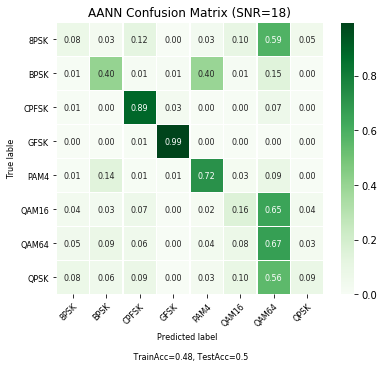

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

modulation_order = []
modulation_order_dict = dict()

for key,value in output.items():
    modulation_order_dict[np.argmax(value)] = str(key)
    
for i in range(8):
    modulation_order.append(modulation_order_dict[i])
    
    
    
cmDataFrame = pd.DataFrame(cm_norm, index=modulation_order, columns = modulation_order)
plt.figure(figsize=(6, 5))
ax = sns.heatmap(cmDataFrame, annot=True, annot_kws={"size": 8}, fmt='.2f', linewidths=.5, cmap="Greens")

plt.title(f"AANN Confusion Matrix (SNR={snr})")
plt.xlabel("Predicted label  \n\n TrainAcc={:.2}, TestAcc={:.2}".format(acc_train,acc_test), fontsize=8)
plt.ylabel("True lable", fontsize=8)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor", fontsize=8)
plt.setp(ax.get_yticklabels(), fontsize=8)
fig = ax.get_figure()

In [0]:
dic = "/content/drive/My Drive/Colab Notebooks/"
fig.savefig(dic+f"/Pic/ANN/ANN-132-ba{batch}-ep{epoch}-(dout=0)-(SNR={snr}).png", dpi=175, bbox_inches='tight')
print("Plot Saved!")

# Plot Model

In [0]:
import keras
import pydot
import pydotplus
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
keras.utils.vis_utils.pydot = pydot
file = ''
plot_model(classifier,show_shapes=True,show_layer_names=False, to_file='model.png' , rankdir='LR')
plot_model(classifier,show_shapes=True,show_layer_names=False, to_file='model.eps' , rankdir='LR')


# Plot accuracy and loss

In [0]:
import matplotlib.pyplot as plt
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))  
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


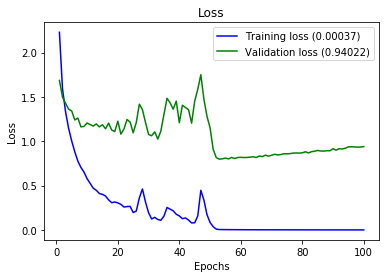

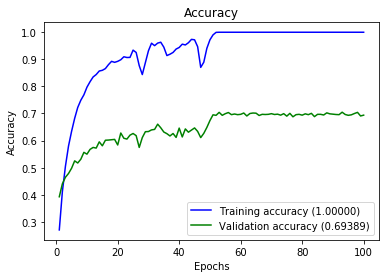

In [41]:
plot_history(classifier.history)

In [24]:
from keras.models import load_model
dic = "/content/drive/My Drive/Colab Notebooks/"

model = load_model(dic+f'SaveModel/ANN-528-ba{batch}-ep{epoch}-(dout=0)-input(IQ)(SNR=all).h5')

print('Model loaded!')

Model loaded!


In [0]:
dic = "/content/drive/My Drive/Colab Notebooks/"
type(classifier.history.history)

